In [1]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import anndata as ad

from scipy.stats import chisquare
from datetime import datetime
import igraph as ig


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Function definitions

In [2]:
def score_modules(ctype, genes_dict):
    dat = sc.read_h5ad('nmf_annotation/run_20230712/'+ ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k, ctrl_size=len(lst), random_state=3523569)

    # Find the column with the highest score and add a new column for the corresponding module.
    score_cols = list(genes_dict.keys())

    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_scoring'] = max_col

    #obs_data = dat.obs.copy()

    return(dat)


def calculate_phenotype_distributions(df,module):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = bground_proportions.index

    # The number of cells scoring highest on this module
    subset = df[df['max_scoring'] == module]
    # Expected proportions based on the celltype proportions
    expected = bground_proportions*len(subset)

    observed = subset['phenotype'].value_counts()[order]

    contig_table = pd.DataFrame({'expected':expected.astype(int),
    'observed':observed,
    'diff':observed-expected.astype(int)})

    pval = chisquare(observed,expected).pvalue

    print(module+': top scoring in ' + str(len(subset))+' cells')
    print(contig_table)
    print('chi2 test p-value: ' + str(pval))
    print('')

    
def plot_score_violins(scores_df,group_col='max_scoring'):
    # Take all columns with module in their name
    module_columns = [col for col in scores_df.columns if 'module' in col]
    module_columns.append(group_col)

    if len(module_columns) > 0:
        violin_df = scores_df[module_columns]

        rows = len(module_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(20, 5 * rows))

        for i in range(len(module_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x=group_col, y=module_columns[i], ax=axs[row][col],order=list(violin_df.drop(columns='max_scoring').columns))
            axs[row][col].tick_params(axis='x', rotation=30)

            # Get the 1st quantile of highest scoring module
            val_80 = violin_df.loc[violin_df[group_col] == module_columns[i],module_columns[i]].quantile(q=0.25)

            # Add horizontal line
            axs[row][col].axhline(y=val_80, color='black', linestyle='--')

        
        plt.show()
    else:
        print("No columns found with 'module' in their names.")


def save_dict_to_excel(dict_with_modules,ctype):
    # Saves the factors to a dataframe and onto an excel sheet
    max_length = max(len(lst) for lst in dict_with_modules.values())
    for key in dict_with_modules:
        dict_with_modules[key].extend([np.nan]*(max_length - len(dict_with_modules[key])))

    df_with_modules = pd.DataFrame.from_dict(dict_with_modules)
    df_with_modules.to_excel(ctype+'_modules_'+datetime.today().strftime('%Y%m%d')+'.xlsx')
    

def create_modules_from_adjacency_matrix(celltype,min_modules_per_connection=5,
                                         min_connections_per_gene=5,min_genes_in_module=10,
                                         plot_clustermap=True):
    
    import random
    random.seed(235693923)
    '''
    This is a function that takes an adjacency matrix of gene connections as 
    input and generates clusters of genes using the Leiden algorithm implemented 
    in the python module igraph. The clusters are then filtered and returned in the
    form of a dictionary with keys as module indexes and values as lists of gene
    names. The function includes a number of default arguments, such as minimum
    number of modules per connection (5), minimum number of connections per gene (5),
    minimum number of genes in a module (10), and a boolean flag to indicate whether
    to plot a clustermap using seaborn (True). The function works by filtering the 
    adjacency matrix to remove weak connections, then using the igraph module to group
    the genes in clusters. The clusters are filtered for minimum size and sorted by size.
    The resulting gene modules are returned as a dictionary, and a seaborn clustermap is
    plotted if desired.
    '''
    adj_df = pd.read_csv('nmf_annotation/run_20230712/'+celltype+'_nmf_derived_gene_adjacencies.csv',index_col=0)

    # Filter connections occurring in fewer than 5 modules
    adj_df[adj_df<=min_modules_per_connection] = 0

    # Filter genes with less than 5 connections
    adj_df = adj_df[adj_df.astype(bool).sum(axis=1) >= min_connections_per_gene]

    # Filter the columns as well
    adj_df = adj_df[adj_df.index] 

    # create graph object
    g = ig.Graph.Adjacency(np.matrix(adj_df),mode='undirected')

    # find clusters
    clusters = g.community_leiden()

    # Extract cluster labels and link them to genes (index)
    labels = pd.Series(clusters.membership)
    labels.index = adj_df.index.copy()

    # Filter the modules by minimum number of genes present and sort them by the number of genes 
    labels_to_keep = list(labels.value_counts()[pd.Series(labels).value_counts() >= min_genes_in_module].index)



    # Save the genes of each module (cluster) to a dictionary
    modules = {}
    for idx,l in enumerate(labels_to_keep):

        # Sort the genes by max values: decreasing
        sorted_genes = list(adj_df[list(adj_df[labels == l].index)].max().sort_values()[::-1].index)
        modules['module'+str(idx)] = sorted_genes
        #modules['module'+str(idx)] = list(adj_df[labels == l].index)

    adj_df = adj_df[[value for key in modules for value in modules[key]]]
    adj_df = adj_df.loc[[value for key in modules for value in modules[key]]]

    if plot_clustermap:
        sns.clustermap(adj_df, cmap='magma', figsize=(6,6),row_cluster=False,col_cluster=False,
                       vmax=np.quantile(np.matrix(adj_df),0.99))


    # Return the dictionary
    return(modules, adj_df)


## Annotating immune cells

Ran celltypist in 'single-cell-immune-celltypist' notebook (7.9.2023)

In [3]:
immune_cell_annotations = pd.read_csv('./celltypist_dir/celltypist_predicted_labels_20230907.csv',index_col=0)
immune_cell_annotations['predicted_labels']


GSM4089152_P2_AACTCTTAGCAGATCG.1     Macrophages
GSM4089152_P2_AACTTTCTCCTCGCAT.1     Macrophages
GSM4089152_P2_AATCCAGGTTGCTCCT.1     Macrophages
GSM4089152_P2_ACCAGTATCGTTTATC.1     Macrophages
GSM4089152_P2_ACGAGCCCACGAAGCA.1     Macrophages
                                        ...     
SCG-PCA22-T-HG_TTTGTCAGTCTAGGTT-1        T cells
SCG-PCA22-T-HG_TTTGTCAGTGGGTCAA-1        T cells
SCG-PCA22-T-HG_TTTGTCAGTGGTTTCA-1        B cells
SCG-PCA22-T-HG_TTTGTCAGTTTAGCTG-1        T cells
SCG-PCA22-T-HG_TTTGTCATCATTTGGG-1        T cells
Name: predicted_labels, Length: 98662, dtype: object

In [4]:
# Create a dataframe for final annotations of all cells
final_annotations = pd.DataFrame()
final_annotations = pd.concat([final_annotations,immune_cell_annotations['predicted_labels']],axis=0)

## Revising the NMF strategy

The full list of modules obtained for individual tumors was filtered to retain only those with at least 5% overlap (by Jaccard index) with at least two other modules. An adjacency matrix was then constructed connecting genes according to the number of individual tumor modules in which they co-occur. Gene–gene connections were filtered out if they occurred in fewer than two individual tumor modules, and genes with fewer than three connections were removed. The graph was clustered using infomap clustering implemented in the igraph package v.1.2.11 (ref. 93). Finally, modules with potential biological relevance were retained by filtering out those with fewer than five genes or without significant overlap with gene ontology terms. The final graph (Extended Data Fig. 3f) was visualized with the Fruchterman–Reingold layout.

- Methods from Barkley et al. Nat. Genetics 2022

## Loading the NMF gene lists and scoring them

### Epithelial

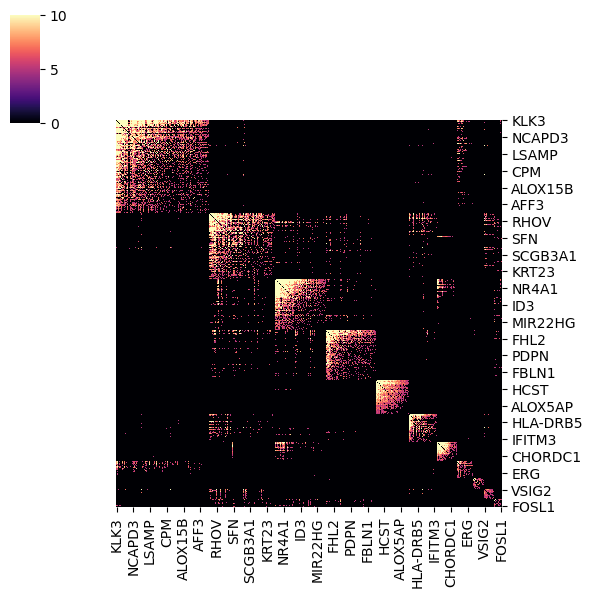

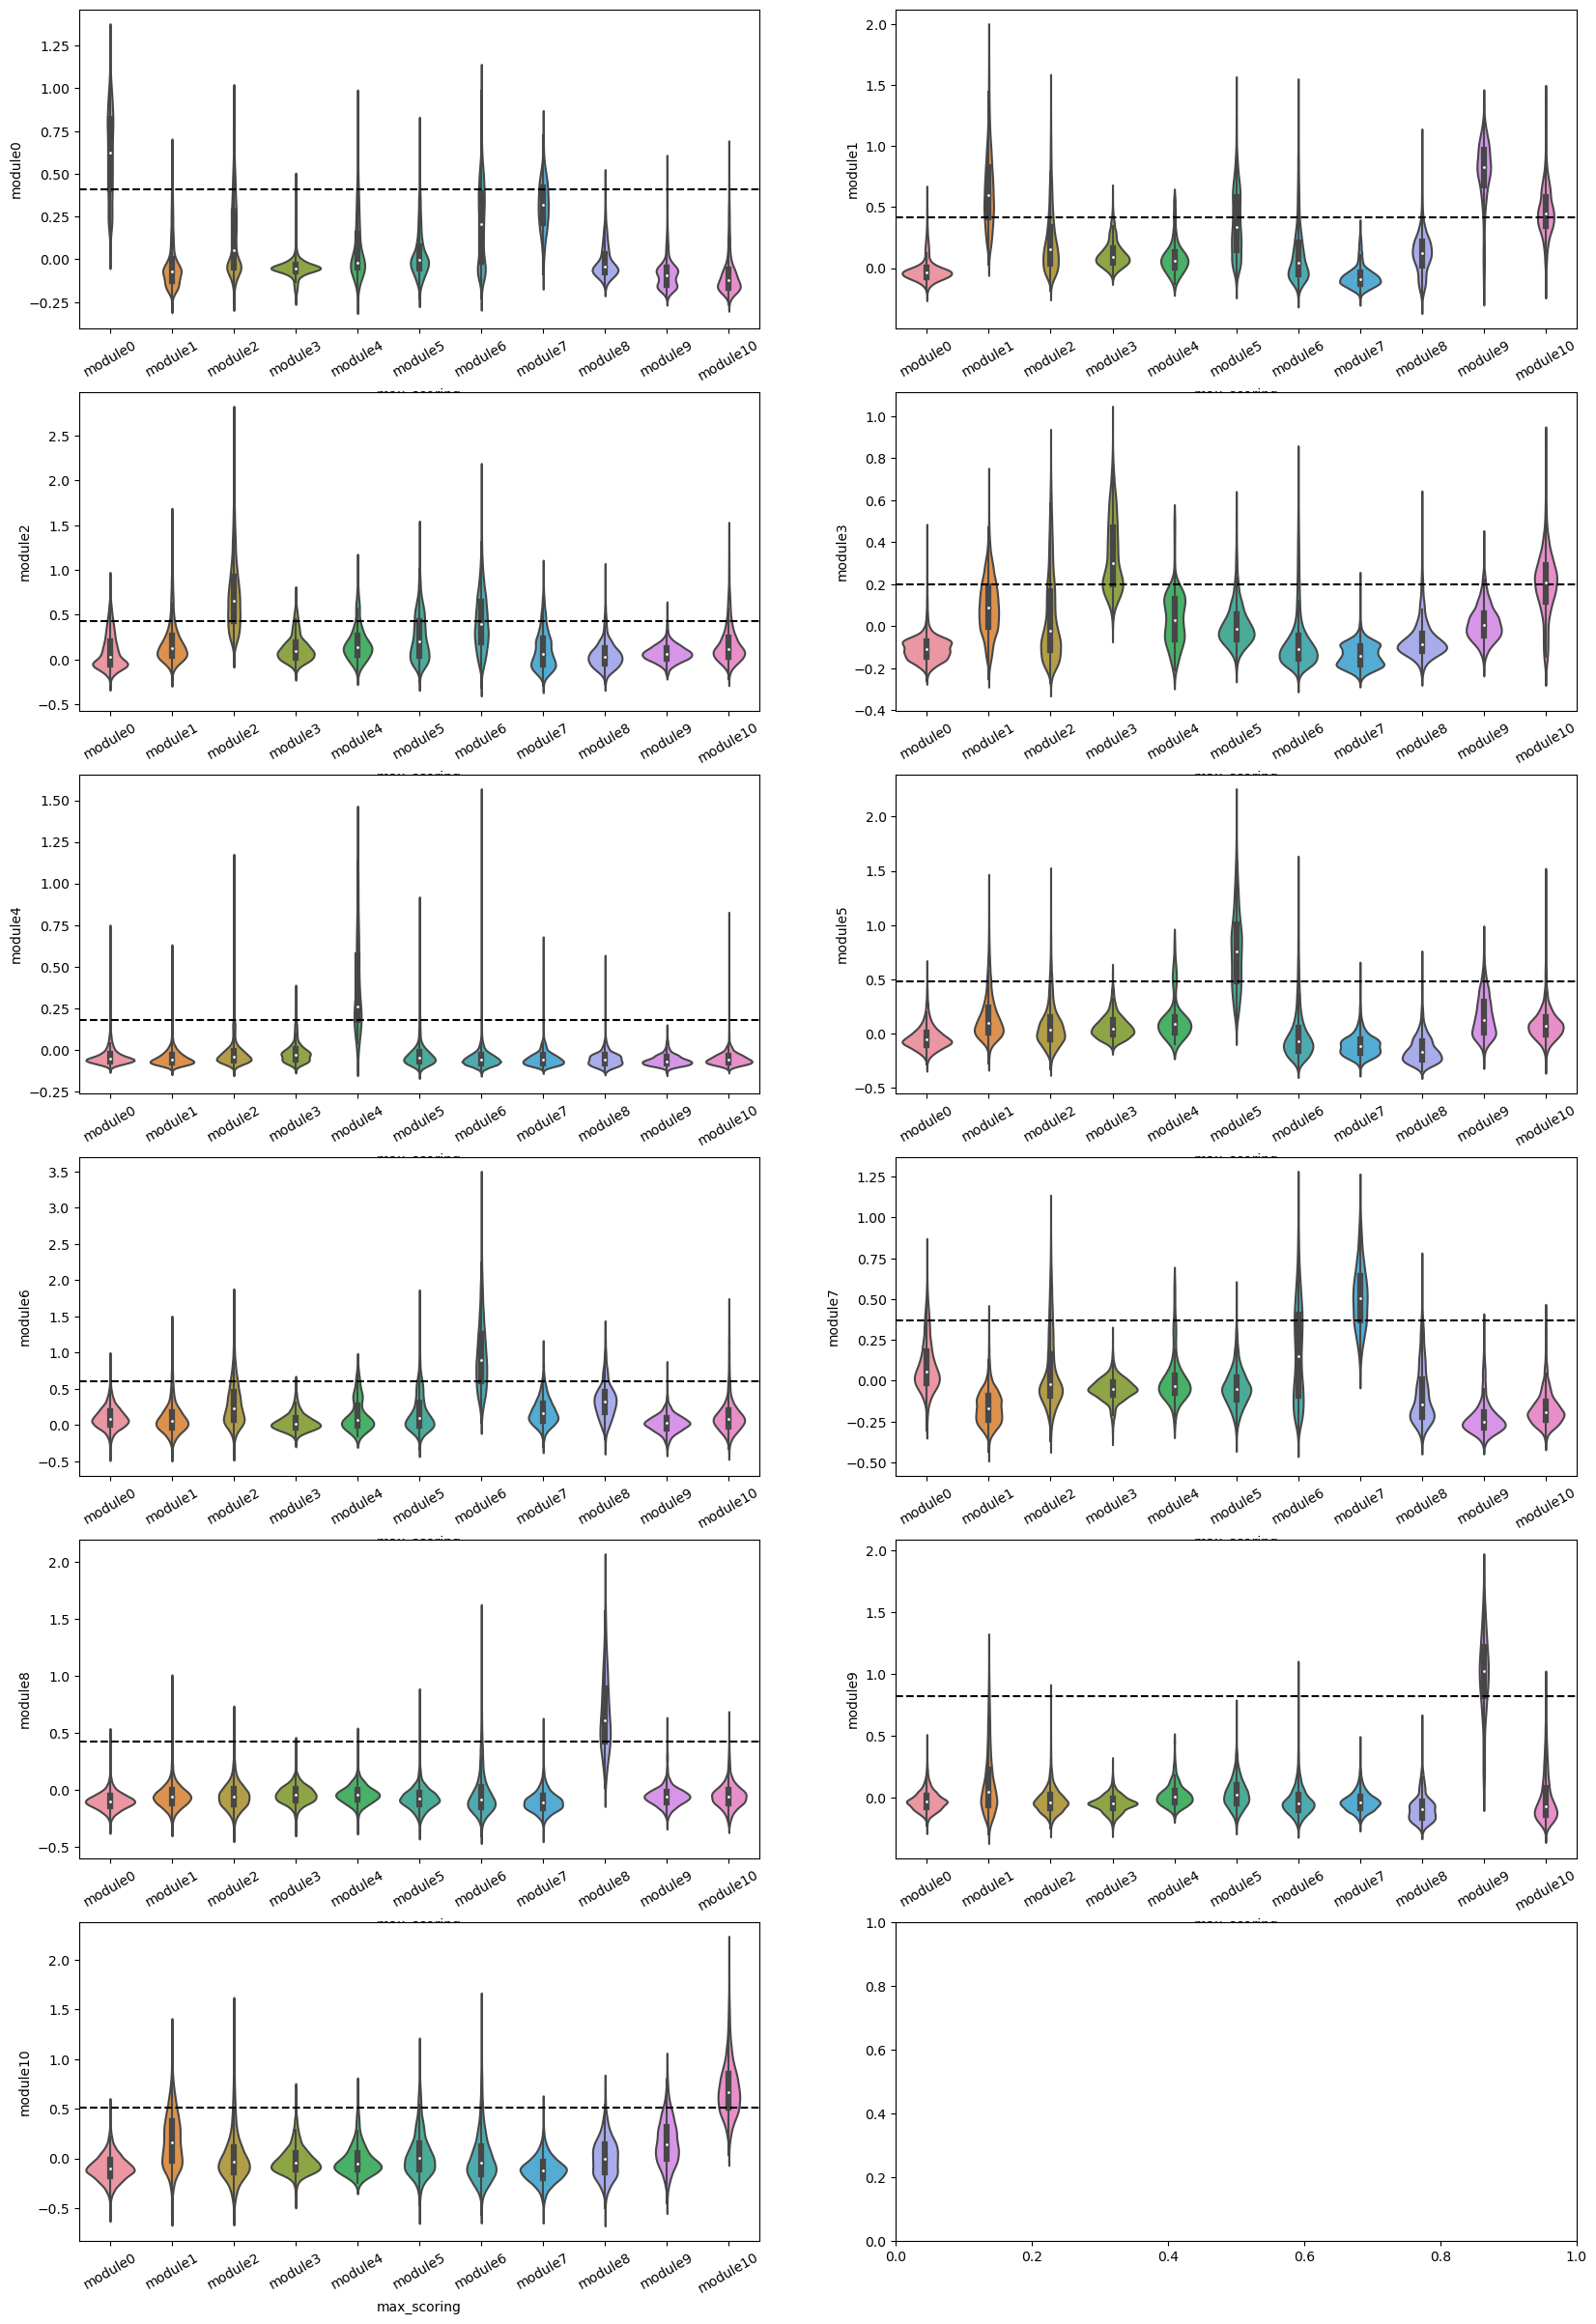

In [5]:
modules_dict, adjacency_df = create_modules_from_adjacency_matrix('Epithelial',min_modules_per_connection=4,min_connections_per_gene=4)
dat = score_modules('Epithelial',modules_dict)
epithelial_scores = dat.obs.copy()

plot_score_violins(epithelial_scores)
save_dict_to_excel(modules_dict,'Epithelial')


In [6]:
keep_track = []
for g1 in adjacency_df.max().sort_values()[::-1][:50].index:
    g2 = adjacency_df[g1].idxmax()
    if (g1 not in keep_track) & (g2 not in keep_track):
        print(g1 + ' <--> ' + g2 + ': '+ str(adjacency_df[g1].max()))
        keep_track.append(g1)
        keep_track.append(g2)

KLK3 <--> KLK2: 38
ACPP <--> RDH11: 34
EGR1 <--> FOSB: 33
CD74 <--> HLA-DRA: 32
JUNB <--> FOS: 32
SLPI <--> WFDC2: 27
CRABP2 <--> ASS1: 26
KRT5 <--> PDLIM1: 25
HSPA1B <--> DNAJB1: 25
DBI <--> KLK4: 24
KRT7 <--> S100A6: 24
GSTP1 <--> KRT19: 22
SERPINF1 <--> DST: 22
MT1F <--> MT1G: 21


In [7]:
for module in list(modules_dict.keys()):
    calculate_phenotype_distributions(epithelial_scores,module)

module0: top scoring in 22587 cells
        expected  observed  diff
PCa        14390     10986 -3404
normal      5154     11386  6232
CRPC        3042       215 -2827
chi2 test p-value: 0.0

module1: top scoring in 14862 cells
        expected  observed  diff
PCa         9468      9489    21
normal      3391      1918 -1473
CRPC        2001      3455  1454
chi2 test p-value: 0.0

module2: top scoring in 13669 cells
        expected  observed  diff
PCa         8708     10284  1576
normal      3119      2551  -568
CRPC        1841       834 -1007
chi2 test p-value: 1.0283826460403222e-204

module3: top scoring in 2306 cells
        expected  observed  diff
PCa         1469      1318  -151
normal       526       949   423
CRPC         310        39  -271
chi2 test p-value: 2.020998237495464e-129

module4: top scoring in 180 cells
        expected  observed  diff
PCa          114       126    12
normal        41        48     7
CRPC          24         6   -18
chi2 test p-value: 0.0003332

In [8]:
# Rename the columns accordingly
replacements = {'module0':'luminal epithelium', 'module1':'mesenchymal epithelium',
                'module2':'stress signaling epithelium', 'module3':'basal epithelium',
                'module4':'drop','module5':'interferon signaling epithelium',
                'module6':'chaperone response epithelium','module7':'cancer epithelium',
                'module8':'intermediate CRPC epithelium','module9':'cycling epithelium',
                'module10':'FOSL1 tumor epithelium'
                }


for k in list(replacements.keys()):
    epithelial_scores['max_scoring'] = epithelial_scores['max_scoring'].replace(k, replacements[k])

In [9]:
final_annotations = pd.concat([final_annotations,epithelial_scores['max_scoring']],axis=0)

### Fibroblast_muscle

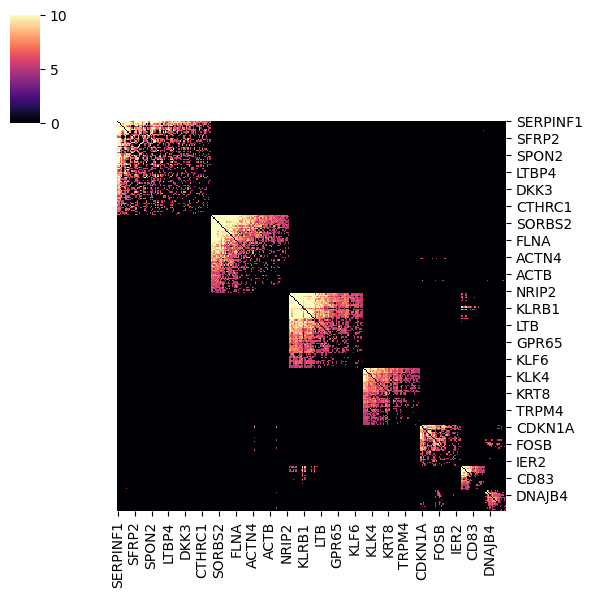

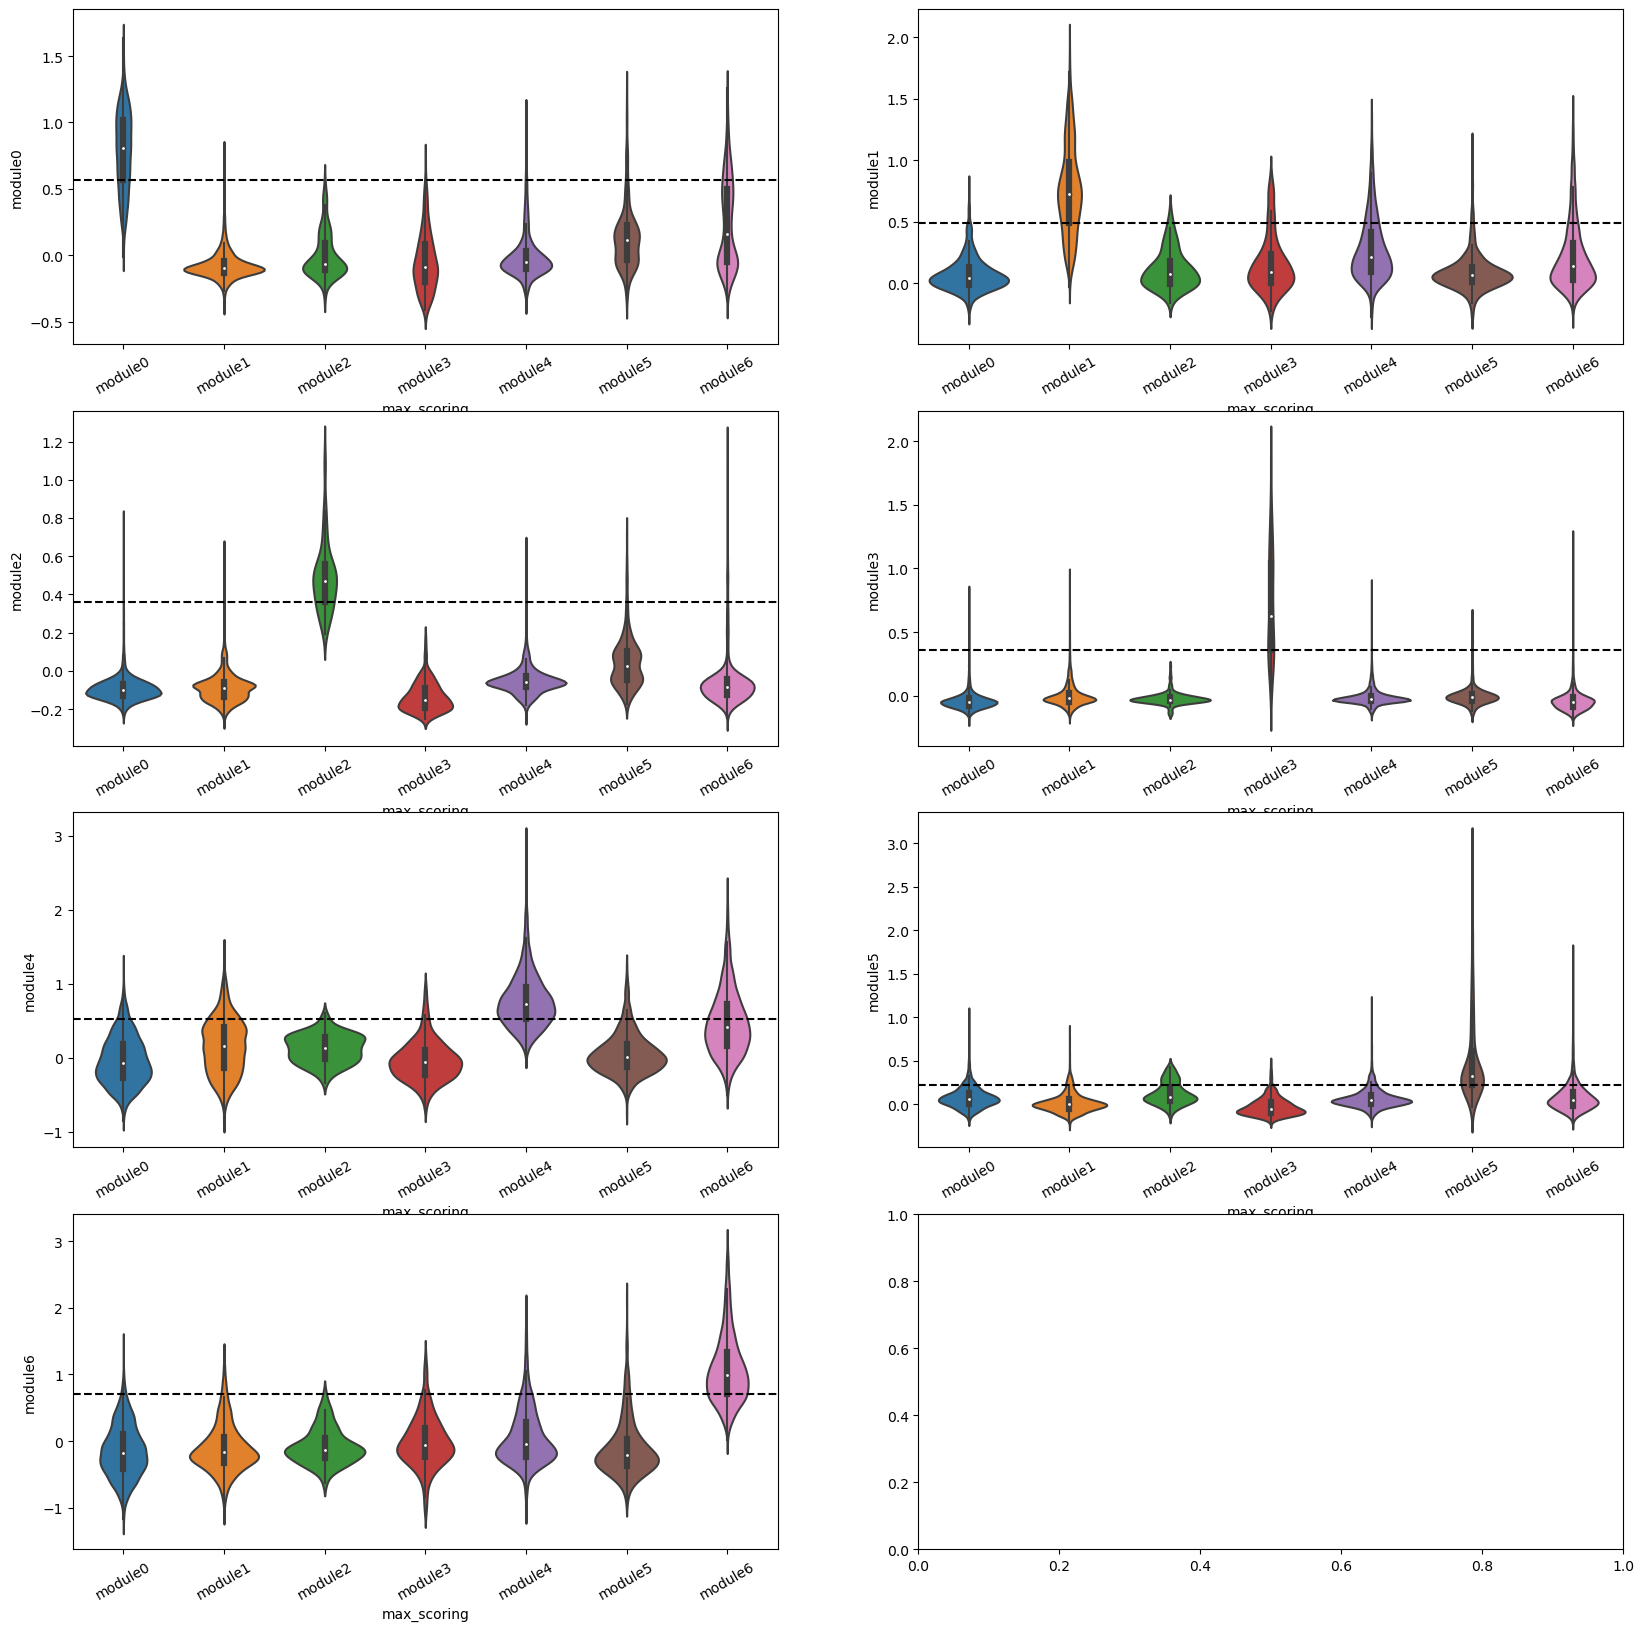

In [10]:
modules_dict,adjacency_df = create_modules_from_adjacency_matrix('Fibroblast_muscle',min_modules_per_connection=4,min_connections_per_gene=4)
dat = score_modules('Fibroblast_muscle',modules_dict)
fibro_scores = dat.obs.copy()

plot_score_violins(fibro_scores)
save_dict_to_excel(modules_dict,'Fibroblast_muscle')

In [11]:
for module in list(modules_dict.keys()):
    calculate_phenotype_distributions(fibro_scores,module)

module0: top scoring in 5066 cells
        expected  observed  diff
PCa         2425      1578  -847
normal      1757      2397   640
CRPC         882      1091   209
chi2 test p-value: 3.0329555763742704e-126

module1: top scoring in 6637 cells
        expected  observed  diff
PCa         3178      3770   592
normal      2303      1843  -460
CRPC        1155      1024  -131
chi2 test p-value: 6.901987688551691e-48

module2: top scoring in 146 cells
        expected  observed  diff
PCa           69        75     6
normal        50        61    11
CRPC          25        10   -15
chi2 test p-value: 0.0026908449136319582

module3: top scoring in 311 cells
        expected  observed  diff
PCa          148       166    18
normal       107        46   -61
CRPC          54        99    45
chi2 test p-value: 6.256020815986667e-17

module4: top scoring in 4772 cells
        expected  observed  diff
PCa         2285      2459   174
normal      1655      2107   452
CRPC         830       206  -6

In [12]:
# Rename the columns accordingly
replacements = {'module0':'fibroblasts', 'module1':'muscle',
                'module2':'drop', 'module3':'drop',
                'module4':'stress response fibroblasts','module5':'drop',
                'module6':'chaperone response fibroblasts'
                }


for k in list(replacements.keys()):
    fibro_scores['max_scoring'] = fibro_scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fibro_scores['max_scoring']],axis=0)

### Endothelial

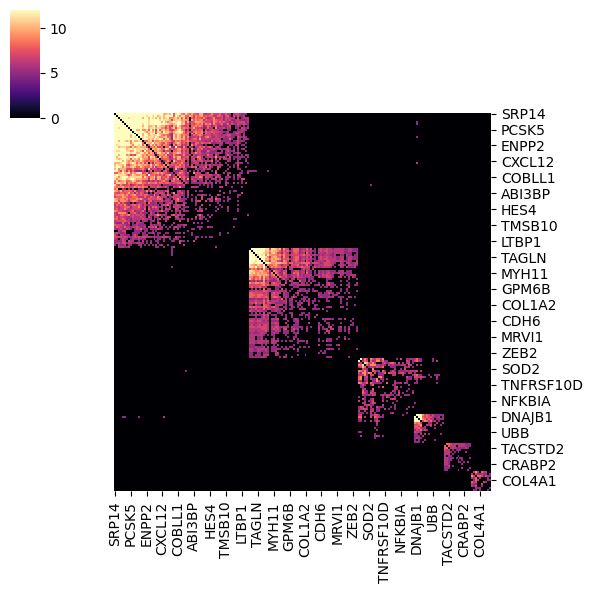

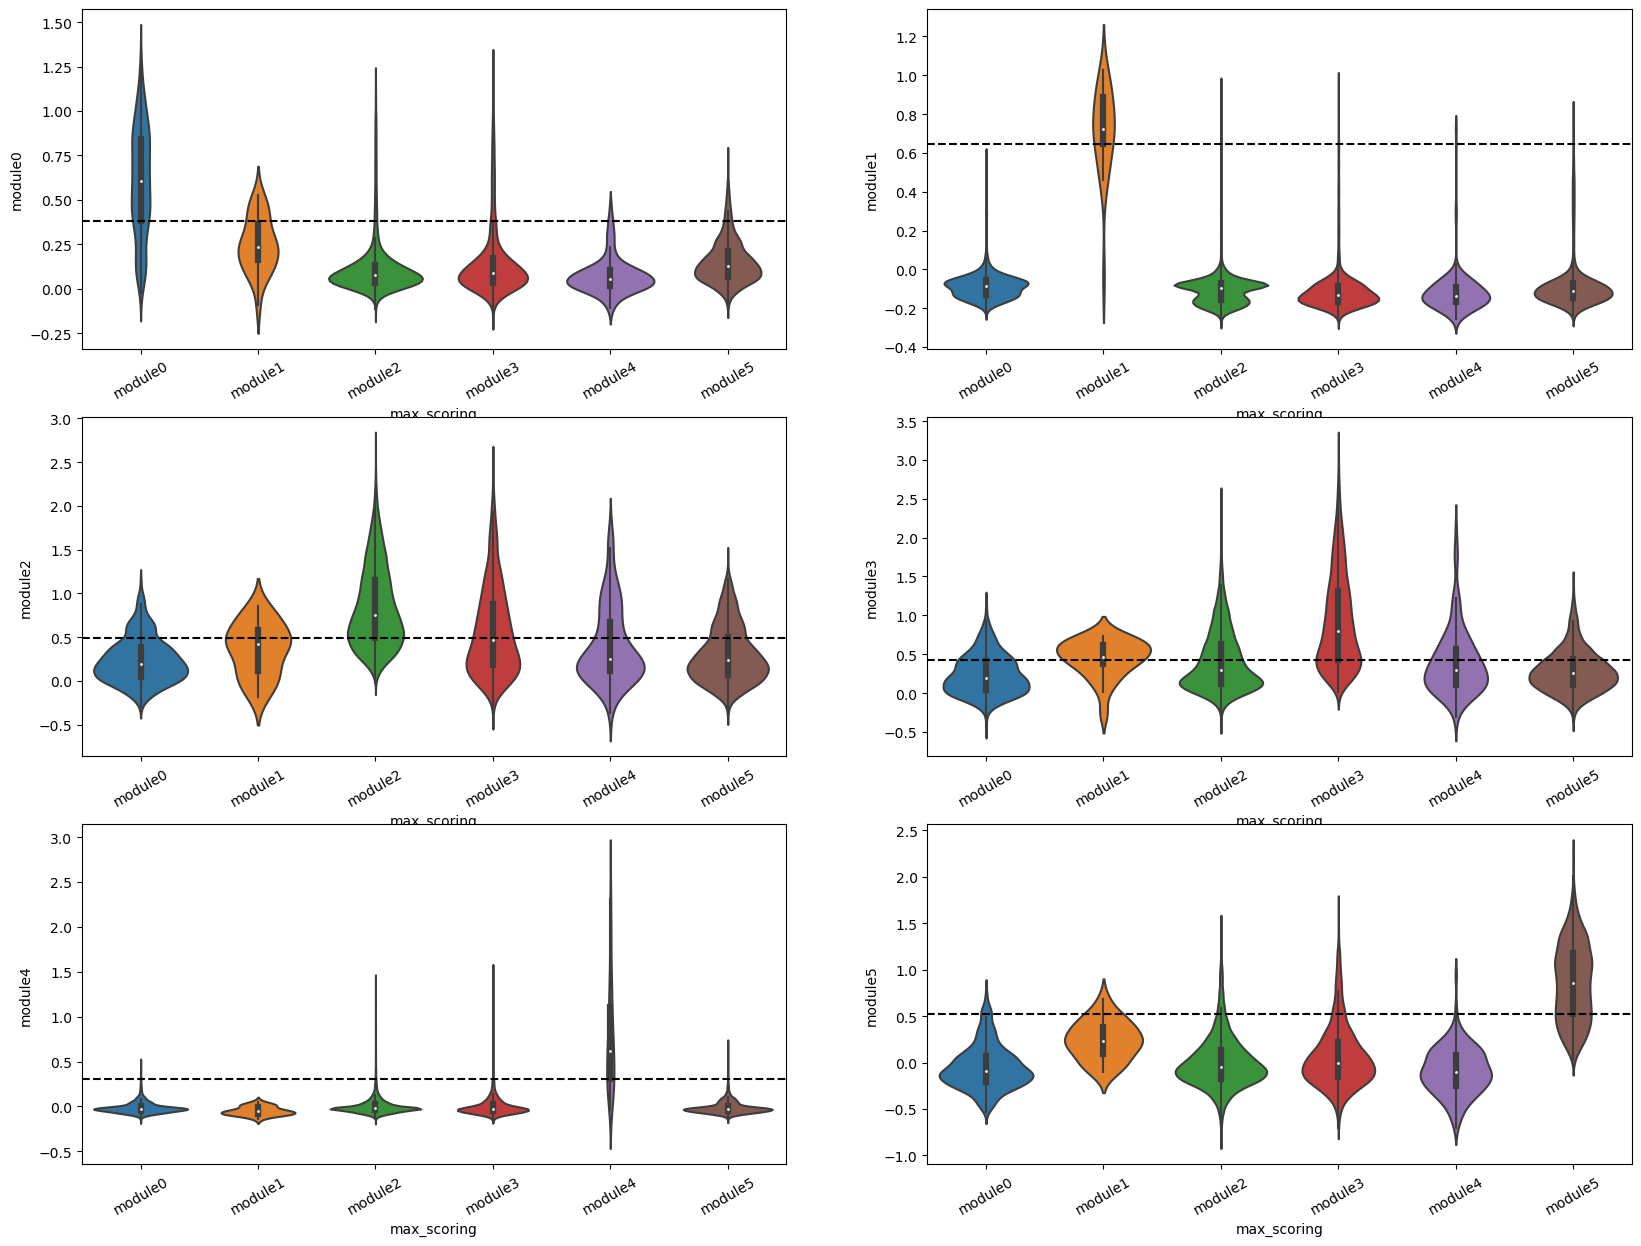

In [13]:
modules_dict, adjacency_df = create_modules_from_adjacency_matrix('Endothelial',min_modules_per_connection=4,min_connections_per_gene=4)
dat = score_modules('Endothelial',modules_dict)

endothelial_scores = dat.obs.copy()

plot_score_violins(endothelial_scores)
save_dict_to_excel(modules_dict,'Endothelial')

In [14]:
for module in list(modules_dict.keys()):
    calculate_phenotype_distributions(endothelial_scores,module)

module0: top scoring in 904 cells
        expected  observed  diff
PCa          577       622    45
normal       275       258   -17
CRPC          51        24   -27
chi2 test p-value: 6.8728822994627e-05

module1: top scoring in 25 cells
        expected  observed  diff
PCa           15        14    -1
normal         7         7     0
CRPC           1         4     3
chi2 test p-value: 0.08258296038936536

module2: top scoring in 13677 cells
        expected  observed  diff
PCa         8729      8435  -294
normal      4171      4725   554
CRPC         776       517  -259
chi2 test p-value: 1.1865426745936204e-37

module3: top scoring in 4939 cells
        expected  observed  diff
PCa         3152      3135   -17
normal      1506      1193  -313
CRPC         280       611   331
chi2 test p-value: 1.2327743220816169e-99

module4: top scoring in 162 cells
        expected  observed  diff
PCa          103       104     1
normal        49        33   -16
CRPC           9        25    16
ch

In [15]:
# Rename the columns accordingly
					
replacements = {'module0':'drop','module1':'drop',
                'module2':'capillary venous endothelium','module3':'chaperone response endothelium',
                'module4':'drop','module5':'angiogenic endothelium'
}


for k in list(replacements.keys()):
    endothelial_scores['max_scoring'] = endothelial_scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,endothelial_scores['max_scoring']],axis=0)

## Merging annotations with data

In [16]:
# Load the data
adata = sc.read_h5ad('aggregate_sc_data_with_broad_annotation_20230712.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [17]:
# Add the neuronal annotated cells
neuronal = adata.obs[adata.obs['refined_celltypes']=='Neuronal']['refined_celltypes']
final_annotations = pd.concat([final_annotations,neuronal],axis=0)


In [18]:
# Rename the final_annotations columns
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [19]:
adata = adata[final_annotations.index]

if (adata.obs.index == final_annotations.index).all():
    adata.obs['final_annotation'] = final_annotations['final_annotation'].copy()
    print('Done')



Done


In [20]:
adata

AnnData object with n_obs × n_vars = 226193 × 14819
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'total_counts', 'n_counts', 'n_genes', 'VI_clusters', 'refined_celltypes', 'final_annotation'
    uns: 'hvg'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]

# Removing factors that were top scorers in less than 100 cells
adata = adata[~(adata.obs['final_annotation']=='drop')]


In [22]:
adata

View of AnnData object with n_obs × n_vars = 223849 × 14819
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'total_counts', 'n_counts', 'n_genes', 'VI_clusters', 'refined_celltypes', 'final_annotation'
    uns: 'hvg'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [23]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

T cells                            71600
luminal epithelium                 22587
mesenchymal epithelium             14862
capillary venous endothelium       13677
stress signaling epithelium        13669
chaperone response epithelium      12614
B cells                            11686
muscle                              6637
cancer epithelium                   5819
ILC                                 5359
fibroblasts                         5066
chaperone response endothelium      4939
Mast cells                          4885
stress response fibroblasts         4772
FOSL1 tumor epithelium              4727
interferon signaling epithelium     4193
chaperone response fibroblasts      3206
angiogenic endothelium              3043
Macrophages                         2952
basal epithelium                    2306
cycling epithelium                  1440
intermediate CRPC epithelium        1137
Monocytes                            994
Plasma cells                         670
DC              

In [24]:
#adata.write('./single_cell_reference_with_nmf_derived_annotations_'+datetime.today().strftime('%Y%m%d')+'.h5ad')

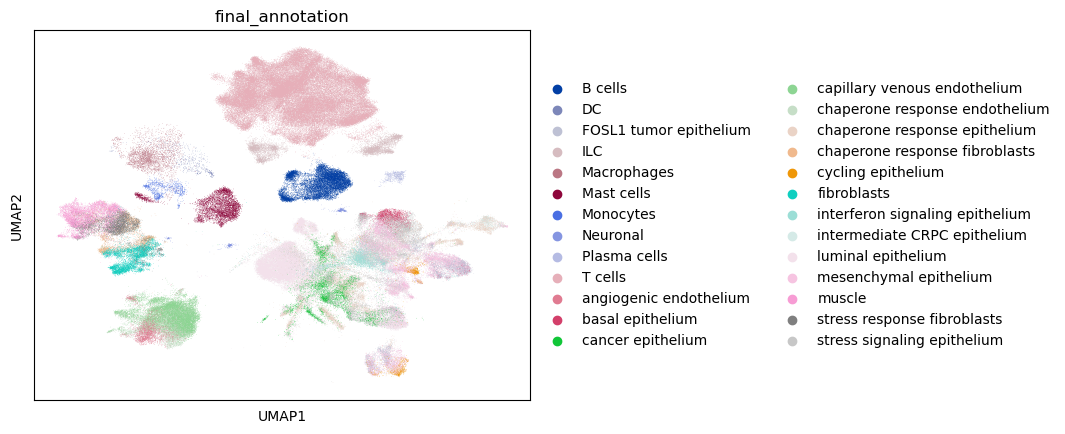

In [26]:
sc.pl.umap(adata,color='final_annotation')

In [29]:
adata.obs

,sample,patient,celltype_orig,phenotype,dataset,total_counts,n_counts,n_genes,VI_clusters,refined_celltypes,final_annotation
GSM4089152_P2_AACTCTTAGCAGATCG.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3392.493240,17119.0,3614,3,Myeloid,Macrophages
GSM4089152_P2_AACTTTCTCCTCGCAT.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3340.923136,13449.0,3213,3,Myeloid,Macrophages
GSM4089152_P2_AATCCAGGTTGCTCCT.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3231.120522,13044.0,3254,3,Myeloid,Macrophages
GSM4089152_P2_ACCAGTATCGTTTATC.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3251.162930,12199.0,3143,3,Myeloid,Macrophages
GSM4089152_P2_ACGAGCCCACGAAGCA.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3108.356698,8338.0,2373,3,Myeloid,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...
SCG-PCA12-T-LG_AAGTCTGAGCTGCAAG-1,hirz_PCA12_T,hirz_PCA12,Fibroblasts,PCa,hirz_2023,918.726686,1453.0,700,46,Neuronal,Neuronal
SCG-PCA12-T-LG_CACCAGGTCAGGCAAG-1,hirz_PCA12_T,hirz_PCA12,Epitheial_Basal,PCa,hirz_2023,1198.075644,4556.0,1783,46,Neuronal,Neuronal
SCG-PCA15-N-HG_TTGGCAACACGCCAGT-1,hirz_PCA15_N,hirz_PCA15,Fibroblasts,normal,hirz_2023,884.440169,865.0,630,46,Neuronal,Neuronal
SCG-PCA17-T-LG_TCTGGAAGTTCGGCAC-1,hirz_PCA17_T,hirz_PCA17,Epitheial_Basal,PCa,hirz_2023,1074.427045,3471.0,1169,46,Neuronal,Neuronal
